In [ ]:
!mkdir -p /content/ships_in_aerial_images
!kaggle datasets download -d siddharthkumarsah/ships-in-aerial-images -p /content/ships_in_aerial_images
!cd /content/ships_in_aerial_images && unzip ships-in-aerial-images.zip


Streaming output truncated to the last 5000 lines.
  inflating: ships-aerial-images/train/labels/x0593_png.rf.33fd03bd0d9896e31b73ac56c1e458c8.txt  
  inflating: ships-aerial-images/train/labels/x0594_png.rf.1a86349573567a368a653b5b39fff4af.txt  
  inflating: ships-aerial-images/train/labels/x0594_png.rf.ff6551627101ade7c4ecd6887fa45546.txt  
  inflating: ships-aerial-images/train/labels/x0595_png.rf.bc03f4a3bc686c5d239d8552ce57b5f5.txt  
  inflating: ships-aerial-images/train/labels/x0597_png.rf.918ed233995c3645a1ca8d14bf35a81c.txt  
  inflating: ships-aerial-images/train/labels/x0598_png.rf.94d8be92f98bf3ff36cf9f51b1e17bc9.txt  
  inflating: ships-aerial-images/train/labels/x0598_png.rf.a5b224c7880ba832c9d6d5aba3123e28.txt  
  inflating: ships-aerial-images/train/labels/x0599_png.rf.d215436f7b245cf0a244ab1c79118c83.txt  
  inflating: ships-aerial-images/train/labels/x0600_png.rf.6d245857b874aeb58d67bfee5f0d8837.txt  
  inflating: ships-aerial-images/train/labels/x0601_png.rf.0e026c33

In [ ]:
!pip install ultralytics opencv-python matplotlib seaborn squarify pandas kaggle
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 23.8 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


Checking if the training images directory exists: /content/ships_in_aerial_images/ships-aerial-images/train/images


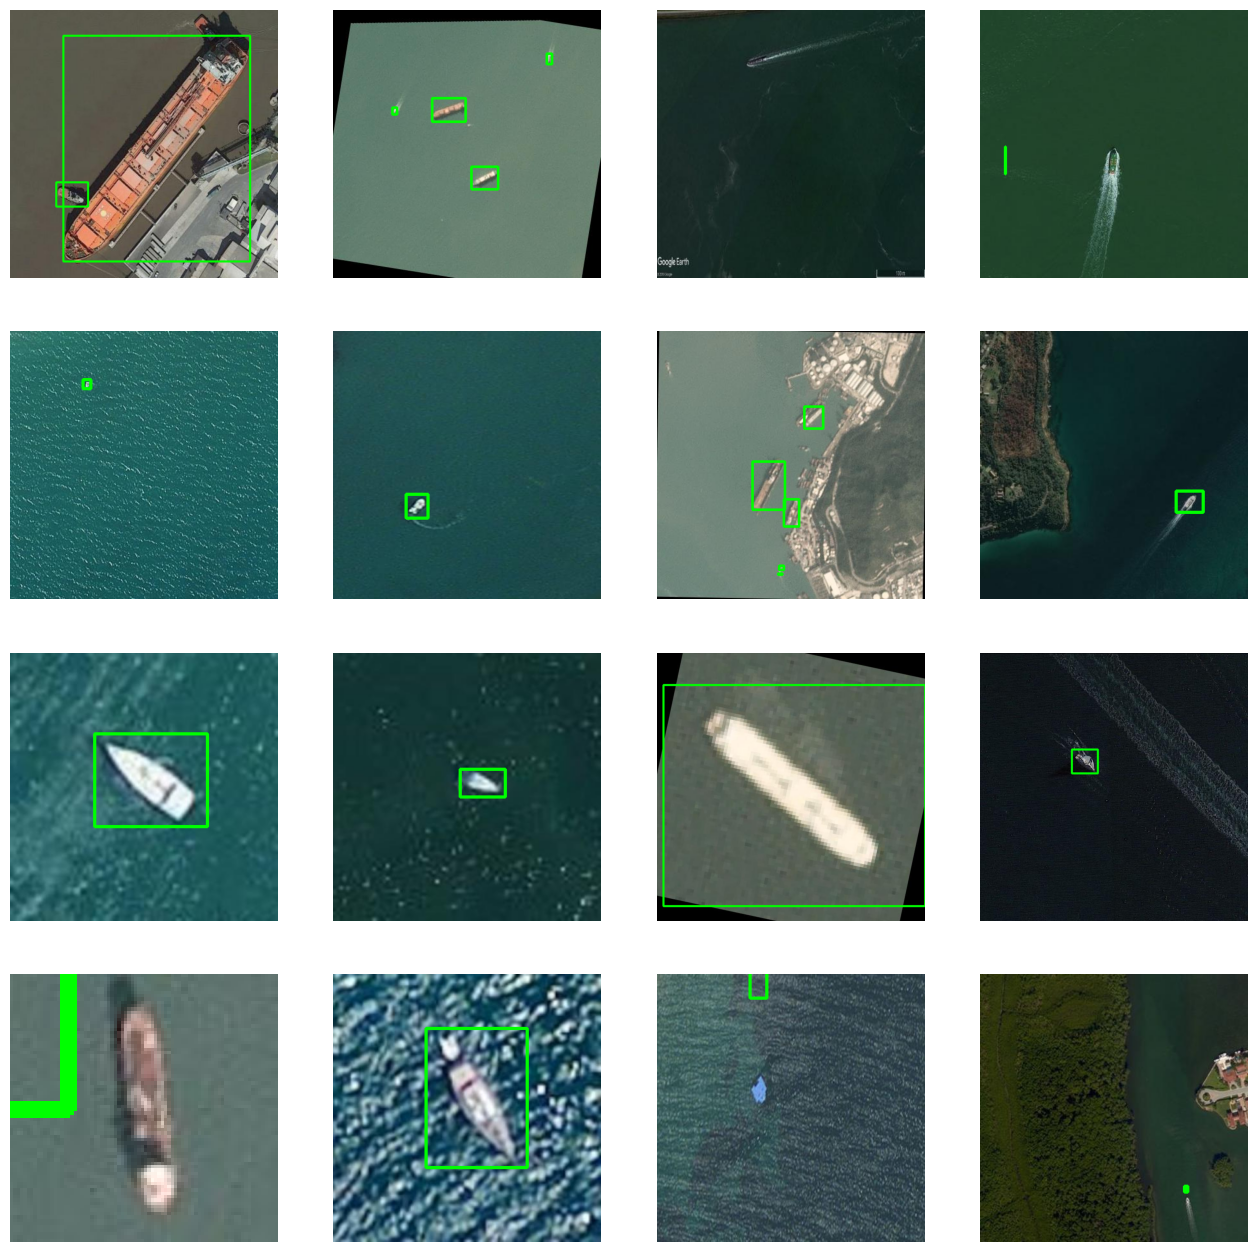

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import pandas as pd

# Set up seaborn for plotting
sns.set_style('darkgrid')

# Define paths for Colab
train_images = '/content/ships_in_aerial_images/ships-aerial-images/train/images'
train_labels = '/content/ships_in_aerial_images/ships-aerial-images/train/labels'

# Print to confirm the paths are correct
print(f"Checking if the training images directory exists: {train_images}")

if not os.path.exists(train_images):
    raise FileNotFoundError(f"The directory {train_images} does not exist.")

# List all image files
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop through the random images and plot detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the corresponding labels
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)

    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over labels and draw bounding boxes
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])

        # Draw bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    # Display image with detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()


In [ ]:
import os

# List files in the extracted dataset directory
print(os.listdir('/content/ships_in_aerial_images/ships-aerial-images/'))


['test', 'data.yaml', 'valid', 'train']


In [ ]:
from ultralytics import YOLO
import os
import pandas as pd

# Load YOLO model
model = YOLO('yolov8n.pt')

# Ensure the save directory exists
save_dir = '/content/drive/MyDrive/runs/detect/train17'
os.makedirs(save_dir, exist_ok=True)

# Training the model with reduced epochs, smaller image size, and lower batch size due to longer training time
model.train(data='/content/ships_in_aerial_images/ships-aerial-images/valid/data.yaml',
            epochs=10,
            imgsz=512,
            seed=42,
            batch=4,
            workers=4,
            val=False)

# Extract training metrics
metrics = model.metrics

# Store the results in a DataFrame
results_data = {
    'train/box_loss': [metrics.box_loss],
    'train/obj_loss': [metrics.obj_loss],
    'train/cls_loss': [metrics.cls_loss],
    'val/box_loss': [metrics.box_loss_val],
    'val/obj_loss': [metrics.obj_loss_val],
    'val/cls_loss': [metrics.cls_loss_val],
    'precision': [metrics.precision],
    'recall': [metrics.recall],
    'mAP_50': [metrics.map50],
    'mAP_50-95': [metrics.map],
}

df = pd.DataFrame(results_data)

# Save the results to CSV in the save directory
csv_path = os.path.join(save_dir, 'training_results.csv')
df.to_csv(csv_path, index=False)

print(f"Training completed and results saved to '{csv_path}'.")


Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/ships_in_aerial_images/ships-aerial-images/valid/data.yaml, epochs=10, time=None, patience=100, batch=4, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

train: Scanning /content/ships_in_aerial_images/ships-aerial-images/train/labels.cache... 9697 images, 351 backgrounds, 2 corrupt: 100%|██████████| 9697/9697 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/ships_in_aerial_images/ships-aerial-images/train/images/1__20180714_180427_1029__-118-20071740708637_33-73029905538088_png.rf.330efa80ecbf49d6ceac7071288d64b4.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0249]
train: WARNING ⚠️ /content/ships_in_aerial_images/ships-aerial-images/train/images/1__20180714_180427_1029__-118-21100741654266_33-732092454738826_png.rf.7243f2b58b505e51950850f4b26081ba.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0079]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 709, len(boxes) = 19454. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01,


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/ships_in_aerial_images/ships-aerial-images/valid/labels.cache... 2165 images, 68 backgrounds, 0 corrupt: 100%|██████████| 2165/2165 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 172, len(boxes) = 3720. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.711G      1.858      2.588      1.583          2        512: 100%|██████████| 2424/2424 [05:14<00:00,  7.72it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.629G      1.844      1.898      1.576          3        512: 100%|██████████| 2424/2424 [04:47<00:00,  8.44it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.617G      1.796      1.746      1.528          6        512: 100%|██████████| 2424/2424 [04:49<00:00,  8.37it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.621G      1.717      1.635      1.473          3        512: 100%|██████████| 2424/2424 [04:48<00:00,  8.41it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.627G      1.644      1.543      1.417          3        512: 100%|██████████| 2424/2424 [04:51<00:00,  8.31it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.596G      1.581      1.429      1.384          4        512: 100%|██████████| 2424/2424 [04:45<00:00,  8.48it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.602G      1.526       1.33      1.345          8        512: 100%|██████████| 2424/2424 [04:46<00:00,  8.46it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.621G      1.494      1.299      1.324          4        512: 100%|██████████| 2424/2424 [04:45<00:00,  8.49it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.629G      1.453      1.242      1.293          3        512: 100%|██████████| 2424/2424 [04:48<00:00,  8.40it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.602G      1.404      1.183      1.255          2        512: 100%|██████████| 2424/2424 [04:42<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:26<00:00, 10.05it/s]


                   all       2165       3720      0.512      0.345      0.397      0.229

10 epochs completed in 0.818 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:18<00:00, 14.85it/s]


                   all       2165       3720      0.515      0.343      0.397      0.228
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train3


AttributeError: 'DetMetrics' object has no attribute 'box_loss'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (dict of str): A dict of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    

In [ ]:
model.train(data="/content/ships_in_aerial_images/ships-aerial-images/valid/data.yaml", epochs=2, batch=8, imgsz=640, resume=False, save_period=1)


Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/train3/weights/last.pt, data=/content/ships_in_aerial_images/ships-aerial-images/valid/data.yaml, epochs=2, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=

train: Scanning /content/ships_in_aerial_images/ships-aerial-images/train/labels.cache... 9697 images, 351 backgrounds, 2 corrupt: 100%|██████████| 9697/9697 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/ships_in_aerial_images/ships-aerial-images/train/images/1__20180714_180427_1029__-118-20071740708637_33-73029905538088_png.rf.330efa80ecbf49d6ceac7071288d64b4.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0249]
train: WARNING ⚠️ /content/ships_in_aerial_images/ships-aerial-images/train/images/1__20180714_180427_1029__-118-21100741654266_33-732092454738826_png.rf.7243f2b58b505e51950850f4b26081ba.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0079]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 709, len(boxes) = 19454. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/ships_in_aerial_images/ships-aerial-images/valid/labels.cache... 2165 images, 68 backgrounds, 0 corrupt: 100%|██████████| 2165/2165 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 172, len(boxes) = 3720. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      2.07G      1.648      1.494      1.507         29        640: 100%|██████████| 1212/1212 [04:39<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:21<00:00,  6.33it/s]


                   all       2165       3720      0.526      0.341      0.364      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      1.78G      1.607       1.44      1.456         75        640: 100%|██████████| 1212/1212 [04:26<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  6.14it/s]


                   all       2165       3720       0.51      0.409      0.385      0.204

2 epochs completed in 0.166 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:22<00:00,  5.99it/s]


                   all       2165       3720      0.508      0.411      0.385      0.204
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7db65bcf1e70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
import pandas as pd

# Load the old and new results files
df_old = pd.read_csv('/content/runs/detect/train3/results.csv')
df_new = pd.read_csv('/content/runs/detect/train6/results.csv')

# Combine the dataframes
df_combined = pd.concat([df_old, df_new], ignore_index=True)

# Save the combined dataframe to a new file
df_combined.to_csv('/content/runs/detect/train6/results_combined.csv', index=False)


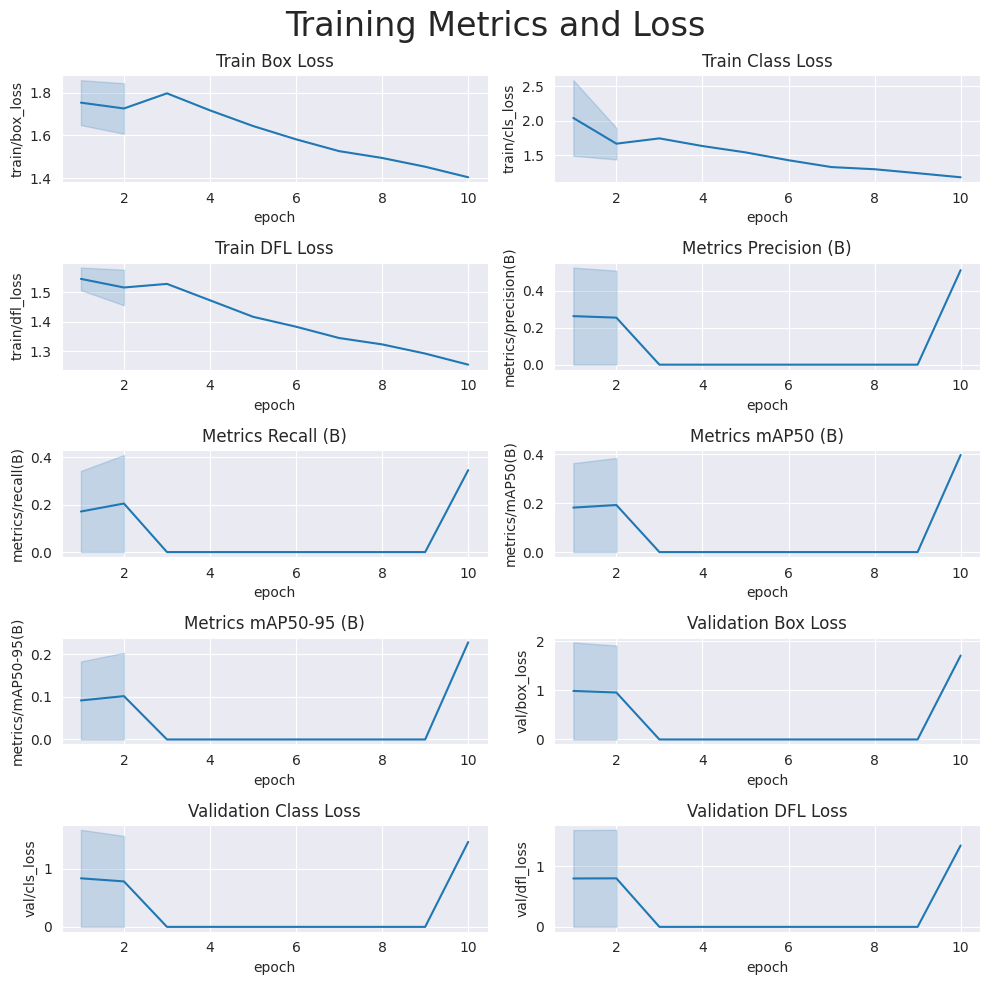

In [ ]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/content/runs/detect/train6/results_combined.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [ ]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/content/runs/detect/train3/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/ships_in_aerial_images/ships-aerial-images/valid/labels.cache... 2165 images, 68 backgrounds, 0 corrupt: 100%|██████████| 2165/2165 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 172, len(boxes) = 3720. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 136/136 [00:17<00:00,  7.58it/s]


                   all       2165       3720      0.646      0.299      0.499      0.334
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


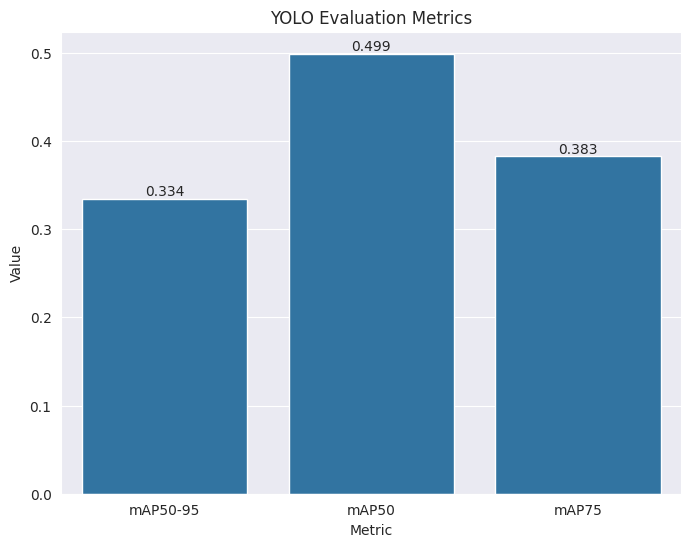

In [ ]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

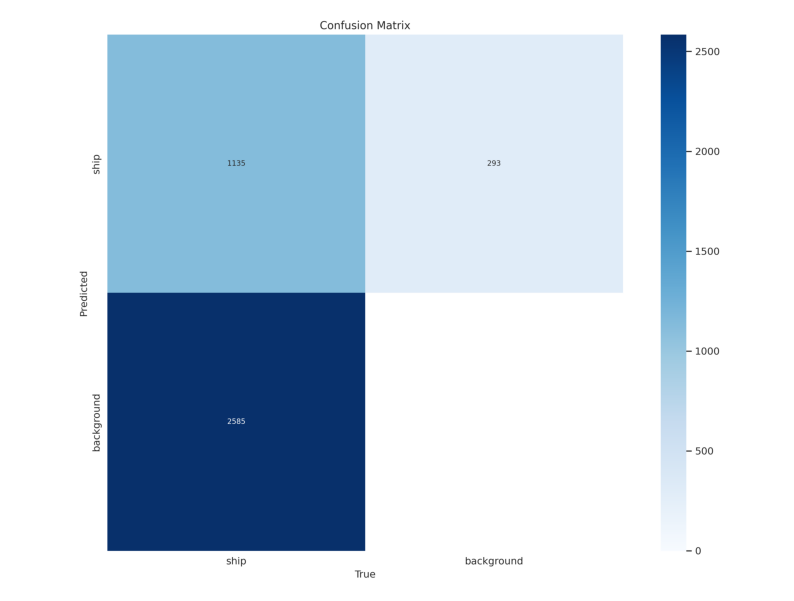

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the confusion matrix image file
img = mpimg.imread('/content/runs/detect/train3/confusion_matrix.png')

# Plot the confusion matrix image
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(img)
ax.axis('off')
plt.show()


In [ ]:
import numpy as np

# Confusion matrix values
TP = 1135  # True Positives
TN = 2585  # True Negatives
FP = 293   # False Positives
FN = 0     # False Negatives

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Print the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 92.70%


In [ ]:
# Function to perform ship detections
def ship_detect(img_path):

    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()

    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img


0: 512x512 1 ship, 11.7ms
Speed: 3.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 6.9ms
Speed: 3.2ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 ship, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 ship, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 ship, 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1,

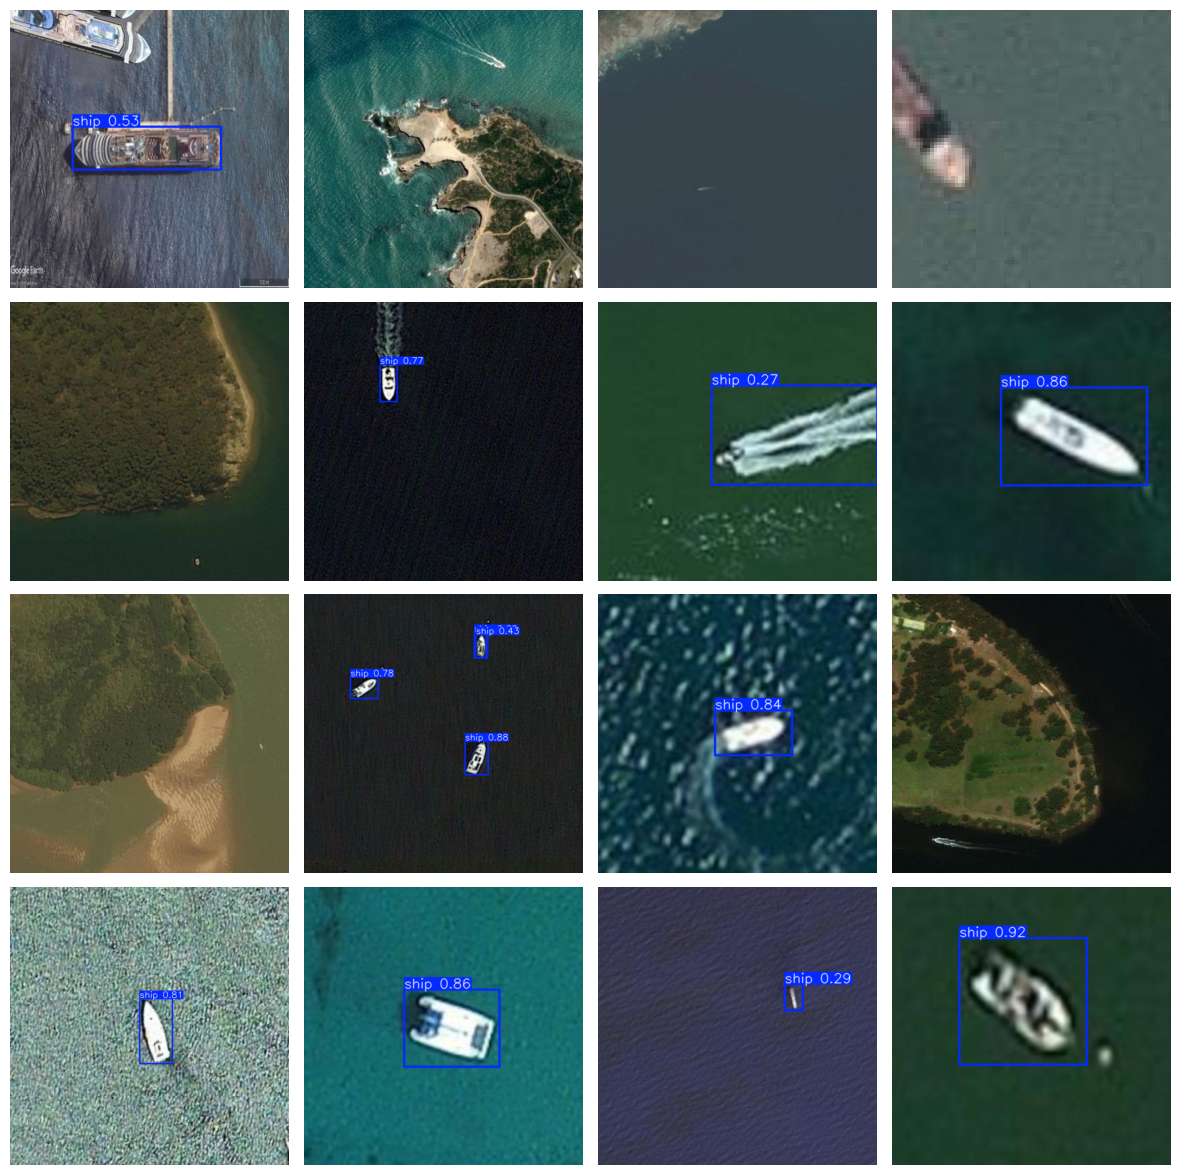

In [ ]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/content/ships_in_aerial_images/ships-aerial-images/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):

    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4

    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = ship_detect(img_path)

    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)